/tmp/ipython-input-461176508.py:47: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(seir_model, y0, t, args=(sigma, phi, kappa, epsilon, gamma, alpha, rho, eta, beta, tau, delta))


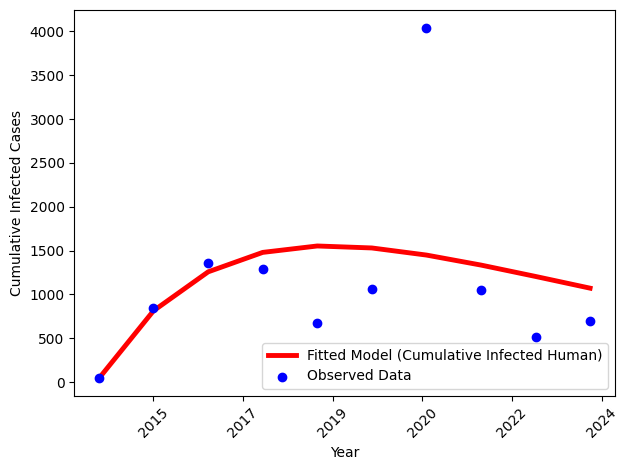

 0.04043, 0.26686, 0.69935, 0.28222, 0.14750, 0.79066, 0.57799, 0.71383, 0.90718, 0.76361, 0.80223


In [ ]:
# New Try

import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# SEIR model with cumulative infections
def seir_model(y, t, sigma, phi, kappa, epsilon, gamma, alpha, rho, eta, beta, tau, delta ):
    S_u, S_a, E_h, I_a, I_s, R, M, S_v, E_v, I_v = y
    N_h = S_u + S_a + E_h + I_a + I_s + R
    N_v = S_v + E_v + I_v

    Lambda_h = 858243;
    Lambda_v = 375103;
    mu = 0.0142;
    mu_v = 17.32;
    mu1 = 0.1;
    mu2 = 0.01;
    r = 0.7;
    b = 0.5;
    c = 0.4;
    d = 0.01;
    e = 0.65;


    dS_udt = r*Lambda_h - (b * beta * I_v * S_u) / (N_h) - sigma * S_u * M - mu * S_u   + phi * S_a
    dS_adt = (1-r)*Lambda_h - ((1-eta) * (c * beta * I_v * S_a)) / (N_h) + sigma * S_u * M - (phi + mu) * S_a
    dE_hdt = ((1-eta) * (c * beta * I_v * S_a)) / (N_h) + (b * beta * I_v * S_u) / (N_h) - (kappa*epsilon + mu)* E_h
    dI_adt = kappa * epsilon * E_h - (gamma + mu + mu1) * I_a
    dI_sdt = (1-kappa) * epsilon * E_h - (alpha + mu + mu2) * I_s
    dRdt = gamma * I_a + alpha * I_s - mu * R
    dMdt = tau*I_s - delta * M
    dS_vdt = Lambda_v - (d * beta * S_v * I_a) / (N_h) - (e * beta * S_v * I_s) / (N_h) - mu_v * S_u
    dE_vdt = (d * beta * S_v * I_a) / (N_h) + (e * beta * S_v * I_s) / (N_h) - (rho + mu_v) * E_v
    dI_vdt = rho * E_v - mu_v * I_v

    return [dS_udt, dS_adt, dE_hdt, dI_adt, dI_sdt, dRdt, dMdt, dS_vdt, dE_vdt, dI_vdt]

# Log-likelihood function for cumulative cases
def log_likelihood(params, t, observed_cumulative):
    sigma, phi, kappa, epsilon, gamma, alpha, rho, eta, beta, tau, delta = params
    y0 = [60439692, 1000000, 5000, 42, 20, 3000, 37510300, 49638138, 7802, 1300]  # Initial conditions with C

    solution = odeint(seir_model, y0, t, args=(sigma, phi, kappa, epsilon, gamma, alpha, rho, eta, beta, tau, delta))
    predicted_cumulative = solution[:, 3]  # Extract cumulative infections (C)

    log_likelihood_value = -0.5 * np.sum((observed_cumulative - predicted_cumulative) ** 2)
    return log_likelihood_value

# Load data
file_name = '/content/gujarathchiken.xlsx'  # Ensure correct file path
df = pd.read_excel(file_name)

# Preprocess data
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
years_since_min = df['Year'].dt.year - df['Year'].dt.year.min()
infected = df['Cases'].values  # Reported infected cases

# Initial parameter guess
# initial_guess = [ 0.08473, 0.83287, 0.43009, 0.00266, 0.21907, 0.20535, 0.05258, 0.79134, 0.47570]

initial_guess = [ 0.05666, 0.03243, -0.40926, 0.69632, 0.76371, 0.78879, 0.53146, 0.83064, 0.71918, 0.84074, 0.66546]

# Define the negative log likelihood function for minimization
neg_log_likelihood = lambda params: -log_likelihood(params, years_since_min, infected)

# Define bounds to ensure positive parameters
bounds = [(None, None)] * len(initial_guess)

# Perform minimization
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
# result = minimize(neg_log_likelihood, initial_guess, method='TNC', bounds=bounds)
params = result.x  # Optimized parameters

# Solve ODE with optimized parameters
y0 = [60439692, 1000000, 5000, 42, 20, 3000, 37510300, 49638138, 7802, 1300]

fitted_solution = odeint(seir_model, y0, years_since_min, args=tuple(params))

# Extract the model prediction (Acute cases A)
predicted_A = fitted_solution[:, 3]  # 'A' is at index 2

# Ensure same length
predicted_A = predicted_A[:len(infected)]

# Compute residuals and standard deviation
# residuals = infected - predicted_A
# std_dev = np.std(residuals)

# Define confidence region (95% confidence ~ 1.96*std_dev)
# upper_bound = predicted_A + 1.96 * std_dev
# lower_bound = predicted_A - 1.96 * std_dev

# Debugging: Print initial acute cases
#print("Initial Acute Cases from Solution:", fitted_solution[0, 2])  # Should print 2436

# Plot the results
plt.plot(df['Year'], predicted_A, 'r-', label="Fitted Model (Cumulative Infected Human)", linewidth=3.5)
plt.scatter(df['Year'], infected, color='b', label="Observed Data", zorder=3)

# Fill the confidence region
# plt.fill_between(df['Year'], lower_bound, upper_bound, color='grey', alpha=0.3, label="95% Confidence Region")

plt.xlabel('Year')
plt.ylabel('Cumulative Infected Cases')

# Format x-axis
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(7))
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()
# Print estimated parameters
print(" " + ", ".join([f"{param:.5f}" for param in params]))

# New Section

/tmp/ipython-input-948305405.py:47: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(seir_model, y0, t, args=(sigma, phi, kappa, epsilon, gamma, alpha, rho, eta, beta, tau, delta))
/tmp/ipython-input-948305405.py:81: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  fitted_solution = odeint(seir_model, y0, years_since_min, args=tuple(params))


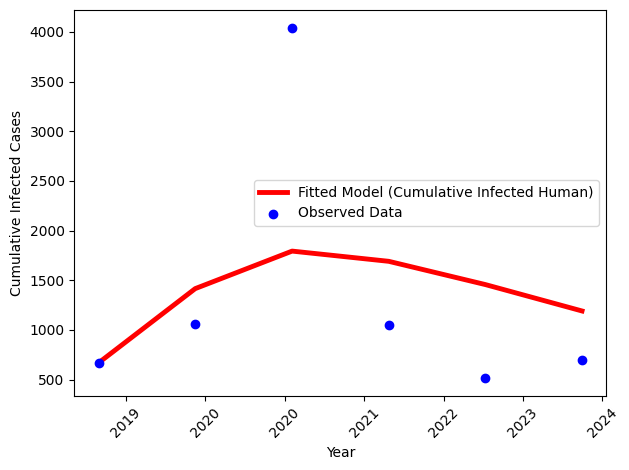

 0.22425, -0.04837, 0.30109, 1.14931, 0.34688, 0.76700, 0.62541, 0.68177, 0.88606, 0.66409, 0.64608


In [ ]:
# New Try

import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# SEIR model with cumulative infections
def seir_model(y, t, sigma, phi, kappa, epsilon, gamma, alpha, rho, eta, beta, tau, delta ):
    S_u, S_a, E_h, I_a, I_s, R, M, S_v, E_v, I_v = y
    N_h = S_u + S_a + E_h + I_a + I_s + R
    N_v = S_v + E_v + I_v

    Lambda_h = 908800;
    Lambda_v = 7008000000;
    mu = 0.0142;
    mu_v = 36.5;

    mu1 = 0.1;
    mu2 = 0.01;
    r = 0.7;
    b = 0.5;
    c = 0.4;
    d = 0.01;
    e = 0.65;


    dS_udt = r*Lambda_h - (b * beta * I_v * S_u) / (N_h) - sigma * S_u * M - mu * S_u   + phi * S_a
    dS_adt = (1-r)*Lambda_h - ((1-eta) * (c * beta * I_v * S_a)) / (N_h) + sigma * S_u * M - (phi + mu) * S_a
    dE_hdt = ((1-eta) * (c * beta * I_v * S_a)) / (N_h) + (b * beta * I_v * S_u) / (N_h) - (kappa*epsilon + mu)* E_h
    dI_adt = kappa * epsilon * E_h - (gamma + mu + mu1) * I_a
    dI_sdt = (1-kappa) * epsilon * E_h - (alpha + mu + mu2) * I_s
    dRdt = gamma * I_a + alpha * I_s - mu * R
    dMdt = tau*I_s - delta * M
    dS_vdt = Lambda_v - (d * beta * S_v * I_a) / (N_h) - (e * beta * S_v * I_s) / (N_h) - mu_v * S_u
    dE_vdt = (d * beta * S_v * I_a) / (N_h) + (e * beta * S_v * I_s) / (N_h) - (rho + mu_v) * E_v
    dI_vdt = rho * E_v - mu_v * I_v

    return [dS_udt, dS_adt, dE_hdt, dI_adt, dI_sdt, dRdt, dMdt, dS_vdt, dE_vdt, dI_vdt]

# Log-likelihood function for cumulative cases
def log_likelihood(params, t, observed_cumulative):
    sigma, phi, kappa, epsilon, gamma, alpha, rho, eta, beta, tau, delta = params
    y0 = [60439692, 1000000, 5000, 669, 200, 3000, 37510300, 49638138, 7802, 1300]  # Initial conditions with C

    solution = odeint(seir_model, y0, t, args=(sigma, phi, kappa, epsilon, gamma, alpha, rho, eta, beta, tau, delta))
    predicted_cumulative = solution[:, 3]  # Extract cumulative infections (C)

    log_likelihood_value = -0.5 * np.sum((observed_cumulative - predicted_cumulative) ** 2)
    return log_likelihood_value

# Load data
file_name = '/content/gujarathchiken2018to2024.xlsx'  # Ensure correct file path
df = pd.read_excel(file_name)

# Preprocess data
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
years_since_min = df['Year'].dt.year - df['Year'].dt.year.min()
infected = df['Cases'].values  # Reported infected cases

# Initial parameter guess
# initial_guess = [ 0.08473, 0.83287, 0.43009, 0.00266, 0.21907, 0.20535, 0.05258, 0.79134, 0.47570]

initial_guess = [ 0.22425, -0.04837, 0.30109, 1.14931, 0.34688, 0.76700, 0.62541, 0.68177, 0.88606, 0.66409, 0.64608]

# Define the negative log likelihood function for minimization
neg_log_likelihood = lambda params: -log_likelihood(params, years_since_min, infected)

# Define bounds to ensure positive parameters
bounds = [(None, None)] * len(initial_guess)

# Perform minimization
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
# result = minimize(neg_log_likelihood, initial_guess, method='TNC', bounds=bounds)
params = result.x  # Optimized parameters

# Solve ODE with optimized parameters
y0 = [60439692, 1000000, 5000, 669, 200, 3000, 37510300, 49638138, 7802, 1300]

fitted_solution = odeint(seir_model, y0, years_since_min, args=tuple(params))

# Extract the model prediction (Acute cases A)
predicted_A = fitted_solution[:, 3]  # 'A' is at index 2

# Ensure same length
predicted_A = predicted_A[:len(infected)]

# Compute residuals and standard deviation
# residuals = infected - predicted_A
# std_dev = np.std(residuals)

# Define confidence region (95% confidence ~ 1.96*std_dev)
# upper_bound = predicted_A + 1.96 * std_dev
# lower_bound = predicted_A - 1.96 * std_dev

# Debugging: Print initial acute cases
#print("Initial Acute Cases from Solution:", fitted_solution[0, 2])  # Should print 2436

# Plot the results
plt.plot(df['Year'], predicted_A, 'r-', label="Fitted Model (Cumulative Infected Human)", linewidth=3.5)
plt.scatter(df['Year'], infected, color='b', label="Observed Data", zorder=3)

# Fill the confidence region
# plt.fill_between(df['Year'], lower_bound, upper_bound, color='grey', alpha=0.3, label="95% Confidence Region")

plt.xlabel('Year')
plt.ylabel('Cumulative Infected Cases')

# Format x-axis
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(7))
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()
# Print estimated parameters
print(" " + ", ".join([f"{param:.5f}" for param in params]))

In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# SEIR model function
def seir_model(y, t, epsilon, omega, beta1, beta2, rho1, rho2, eta, zeta, gamma):
    Su, Sa, I, Sn, Sp, C, R = y
    N=Su+Sa+I+Sn+Sp+C+R

    mu = 0.0148;


    dSudt = 18403527 - (beta1*Su*(Sp+eta*C))/(N) - (epsilon + mu)* Su
    dSadt = epsilon*Su - (beta2*Sa*(Sp+eta*C))/(N) - mu* Sa
    dIdt = (beta1*Su*(Sp+eta*C))/(N) + (beta2*Sa*(Sp+eta*C))/(N) - (mu+0.04) * I
    dSndt = 2576 - (gamma*Sn*(Sp+zeta*C))/(N) - mu * Sn
    dSpdt = (gamma*Sn*(Sp+zeta*C))/(N) - (Sp*(rho1*beta1*Su+rho2*beta2*eta*Sa))/(N) - (mu) * Sp
    dCdt = (Sp*(rho1*beta1*Su+rho2*beta2*eta*Sa))/(N) - (omega + mu + 0.0135) * C
    dRdt = omega * C - (mu) * R
    return [dSudt, dSadt, dIdt, dSndt, dSpdt, dCdt, dRdt]

# Log-likelihood function for optimization
def log_likelihood(params, t, observed_data):
    epsilon, omega, beta1, beta2, rho1, rho2, eta, zeta, gamma = params

    # Corrected initial conditions (ensuring A starts at 2436)
    y0 = [1200000000, 43481564, 21467, 2146700, 214670, 24467, 1000]

    # Solve ODE
    solution = odeint(seir_model, y0, t, args=(epsilon, omega, beta1, beta2, rho1, rho2, eta, zeta, gamma))

    # Extract A (Acute cases) at index 2
    predicted_data = solution[:, 2]

    # Ensure both arrays have the same length
    predicted_data = predicted_data[:len(observed_data)]

    # Compute negative log-likelihood
    log_likelihood_value = -0.5 * np.sum((observed_data - predicted_data) ** 2)
    return log_likelihood_value

# Load data
file_name = '/content/rapeinida.xlsx'  # Ensure correct file path
df = pd.read_excel(file_name)

# Preprocess data
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
years_since_min = df['Year'].dt.year - df['Year'].dt.year.min()
infected = df['Cases'].values  # Reported infected cases

# Initial parameter guess
# initial_guess = [ 0.08473, 0.83287, 0.43009, 0.00266, 0.21907, 0.20535, 0.05258, 0.79134, 0.47570]

initial_guess = [ 0.08970, 0.02855, 0.01503, 0.02173, 0.80798, 0.68398, 0.53350, 0.82337, 0.70617]

# Define the negative log likelihood function for minimization
neg_log_likelihood = lambda params: -log_likelihood(params, years_since_min, infected)

# Define bounds to ensure positive parameters
bounds = [(None, None)] * len(initial_guess)

# Perform minimization
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
# result = minimize(neg_log_likelihood, initial_guess, method='TNC', bounds=bounds)
params = result.x  # Optimized parameters

# Solve ODE with optimized parameters
y0 = [1200000000, 43481564, 21467, 2146700, 214670, 24467, 1000]

fitted_solution = odeint(seir_model, y0, years_since_min, args=tuple(params))

# Extract the model prediction (Acute cases A)
predicted_A = fitted_solution[:, 2]  # 'A' is at index 2

# Ensure same length
predicted_A = predicted_A[:len(infected)]

# Compute residuals and standard deviation
residuals = infected - predicted_A
std_dev = np.std(residuals)

# Define confidence region (95% confidence ~ 1.96*std_dev)
upper_bound = predicted_A + 1.96 * std_dev
lower_bound = predicted_A - 1.96 * std_dev

# Debugging: Print initial acute cases
#print("Initial Acute Cases from Solution:", fitted_solution[0, 2])  # Should print 2436

# Plot the results
plt.plot(df['Year'], predicted_A, 'r-', label="Fitted Model (Cumulative Infected Human)", linewidth=3.5)
plt.scatter(df['Year'], infected, color='b', label="Observed Data", zorder=3)

# Fill the confidence region
plt.fill_between(df['Year'], lower_bound, upper_bound, color='grey', alpha=0.3, label="95% Confidence Region")

plt.xlabel('Year')
plt.ylabel('Cumulative Infected Cases')

# Format x-axis
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(7))
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()
# Print estimated parameters
print(" " + ", ".join([f"{param:.5f}" for param in params]))

FileNotFoundError: [Errno 2] No such file or directory: '/content/rapeinida.xlsx'

/tmp/ipython-input-1738732574.py:49: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(seir_model, y0, t, args=(sigma, phi, kappa, epsilon, gamma, alpha, rho, eta, beta, tau, delta))
/tmp/ipython-input-1738732574.py:89: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  fitted_solution = odeint(seir_model, y0, years_since_min, args=tuple(params))


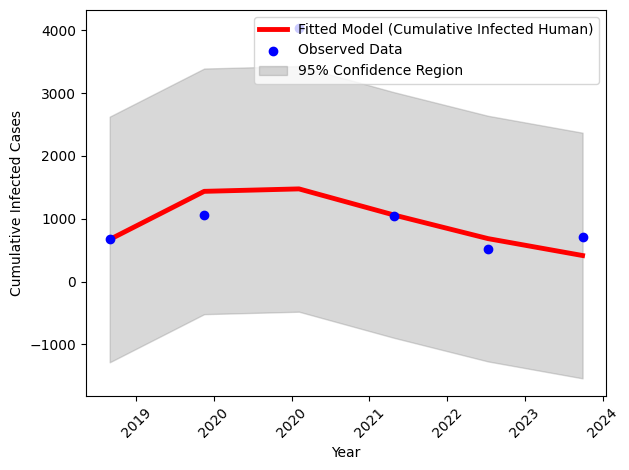

 0.08473, 0.83287, 0.43009, 0.00266, 0.21907, 0.20535, 0.05258, 0.79134, 0.47570, 0.79134, 0.47570


In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# SEIR model function
def seir_model(y, t, sigma, phi, kappa, epsilon, gamma, alpha, rho, eta, beta, tau, delta ):
    S_u, S_a, E_h, I_a, I_s, R, M, S_v, E_v, I_v = y
    N_h = S_u + S_a + E_h + I_a + I_s + R
    N_v = S_v + E_v + I_v

    Lambda_h = 908800;
    Lambda_v = 7008000000;
    mu = 0.0142;
    mu_v = 36.5;

    mu1 = 0.001;
    mu2 = 0.073;
    r = 0.6;
    b = 0.6;
    c = 0.3;
    d = 0.45;
    e = 0.8;


    dS_udt = r*Lambda_h - (b * beta * I_v * S_u) / (N_h) - sigma * S_u * M - mu * S_u   + phi * S_a
    dS_adt = (1-r)*Lambda_h - ((1-eta) * (c * beta * I_v * S_a)) / (N_h) + sigma * S_u * M - (phi + mu) * S_a
    dE_hdt = ((1-eta) * (c * beta * I_v * S_a)) / (N_h) + (b * beta * I_v * S_u) / (N_h) - (kappa*epsilon + mu)* E_h
    dI_adt = kappa * epsilon * E_h - (gamma + mu + mu1) * I_a
    dI_sdt = (1-kappa) * epsilon * E_h - (alpha + mu + mu2) * I_s
    dRdt = gamma * I_a + alpha * I_s - mu * R
    dMdt = tau*I_s - delta * M
    dS_vdt = Lambda_v - (d * beta * S_v * I_a) / (N_h) - (e * beta * S_v * I_s) / (N_h) - mu_v * S_u
    dE_vdt = (d * beta * S_v * I_a) / (N_h) + (e * beta * S_v * I_s) / (N_h) - (rho + mu_v) * E_v
    dI_vdt = rho * E_v - mu_v * I_v

    return [dS_udt, dS_adt, dE_hdt, dI_adt, dI_sdt, dRdt, dMdt, dS_vdt, dE_vdt, dI_vdt]

# Log-likelihood function for optimization
def log_likelihood(params, t, observed_data):
    sigma, phi, kappa, epsilon, gamma, alpha, rho, eta, beta, tau, delta = params

    # Corrected initial conditions (ensuring A starts at 2436)
    y0 = [54400000, 6400000, 1280000, 1280000, 669, 320000, 180480000, 180480000, 9600000, 1920000]

    # Solve ODE
    solution = odeint(seir_model, y0, t, args=(sigma, phi, kappa, epsilon, gamma, alpha, rho, eta, beta, tau, delta))

    # Extract A (Acute cases) at index 2
    predicted_data = solution[:, 4]

    # Ensure both arrays have the same length
    predicted_data = predicted_data[:len(observed_data)]

    # Compute negative log-likelihood
    log_likelihood_value = -0.5 * np.sum((observed_data - predicted_data) ** 2)
    return log_likelihood_value

# Load data
file_name = '/content/gujarathchiken2018to2024.xlsx'  # Ensure correct file path
df = pd.read_excel(file_name)

# Preprocess data
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
years_since_min = df['Year'].dt.year - df['Year'].dt.year.min()
infected = df['Cases'].values  # Reported infected cases

# Initial parameter guess
# initial_guess = [ 0.08473, 0.83287, 0.43009, 0.00266, 0.21907, 0.20535, 0.05258, 0.79134, 0.47570]

initial_guess = [0.08473, 0.83287, 0.43009, 0.00266, 0.21907, 0.20535, 0.05258, 0.79134, 0.47570, 0.79134, 0.47570]

# Define the negative log likelihood function for minimization
neg_log_likelihood = lambda params: -log_likelihood(params, years_since_min, infected)

# Define bounds to ensure positive parameters
bounds = [(None, None)] * len(initial_guess)

# Perform minimization
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
# result = minimize(neg_log_likelihood, initial_guess, method='TNC', bounds=bounds)
params = result.x  # Optimized parameters

# Solve ODE with optimized parameters
y0 = [54400000, 6400000, 1280000, 1280000, 669, 320000, 180480000, 180480000, 9600000, 1920000]

fitted_solution = odeint(seir_model, y0, years_since_min, args=tuple(params))

# Extract the model prediction (Acute cases A)
predicted_A = fitted_solution[:, 4]  # 'A' is at index 2

# Ensure same length
predicted_A = predicted_A[:len(infected)]

# Compute residuals and standard deviation
residuals = infected - predicted_A
std_dev = np.std(residuals)

# Define confidence region (95% confidence ~ 1.96*std_dev)
upper_bound = predicted_A + 1.96 * std_dev
lower_bound = predicted_A - 1.96 * std_dev

# Debugging: Print initial acute cases
#print("Initial Acute Cases from Solution:", fitted_solution[0, 2])  # Should print 2436

# Plot the results
plt.plot(df['Year'], predicted_A, 'r-', label="Fitted Model (Cumulative Infected Human)", linewidth=3.5)
plt.scatter(df['Year'], infected, color='b', label="Observed Data", zorder=3)

# Fill the confidence region
plt.fill_between(df['Year'], lower_bound, upper_bound, color='grey', alpha=0.3, label="95% Confidence Region")

plt.xlabel('Year')
plt.ylabel('Cumulative Infected Cases')

# Format x-axis
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(7))
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()
# Print estimated parameters
print(" " + ", ".join([f"{param:.5f}" for param in params]))

/tmp/ipython-input-2888055483.py:48: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(seir_model, y0, t, args=(sigma, phi, kappa, epsilon, gamma, alpha, rho, eta, beta, tau, delta))


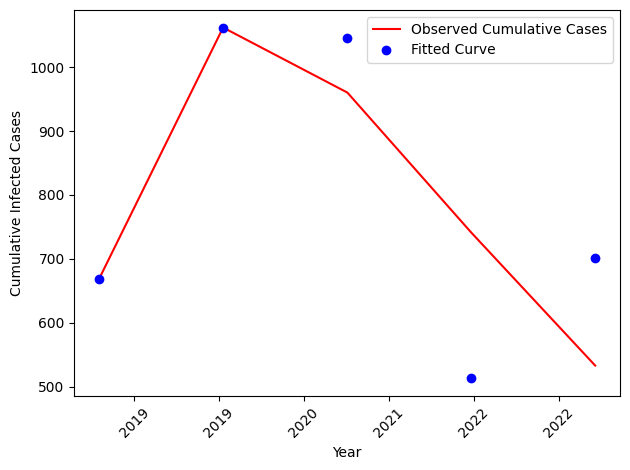

 0.44933, 0.12533, 0.58282, 0.70087, 0.15585, 0.84488, 0.52263, 0.70356, 0.61753, 0.67243, 0.36696


In [ ]:
# New Try

import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# SEIR model with cumulative infections
def seir_model(y, t, sigma, phi, kappa, epsilon, gamma, alpha, rho, eta, beta, tau, delta ):
    S_u, S_a, E_h, I_a, I_s, R, M, S_v, E_v, I_v = y
    N_h = S_u + S_a + E_h + I_a + I_s + R
    N_v = S_v + E_v + I_v

    Lambda_h = 90880000;
    Lambda_v = 70080000;
    mu = 0.0142;
    mu_v = 6.5;

    mu1 = 0.01;
    mu2 = 0.001;
    r = 0.7;
    b = 0.5;
    c = 0.4;
    d = 0.00001;
    e = 0.65;


    dS_udt = r*Lambda_h - (b * beta * I_v * S_u) / (N_h) - sigma * S_u * M - mu * S_u   + phi * S_a
    dS_adt = (1-r)*Lambda_h - ((1-eta) * (c * beta * I_v * S_a)) / (N_h) + sigma * S_u * M - (phi + mu) * S_a
    dE_hdt = ((1-eta) * (c * beta * I_v * S_a)) / (N_h) + (b * beta * I_v * S_u) / (N_h) - (kappa*epsilon + mu)* E_h
    dI_adt = kappa * epsilon * E_h - (gamma + mu + mu1) * I_a
    dI_sdt = (1-kappa) * epsilon * E_h - (alpha + mu + mu2) * I_s
    dRdt = gamma * I_a + alpha * I_s - mu * R
    dMdt = tau*I_s - delta * M
    dS_vdt = Lambda_v - (d * beta * S_v * I_a) / (N_h) - (e * beta * S_v * I_s) / (N_h) - mu_v * S_u
    dE_vdt = (d * beta * S_v * I_a) / (N_h) + (e * beta * S_v * I_s) / (N_h) - (rho + mu_v) * E_v
    dI_vdt = rho * E_v - mu_v * I_v

    return [dS_udt, dS_adt, dE_hdt, dI_adt, dI_sdt, dRdt, dMdt, dS_vdt, dE_vdt, dI_vdt]

# Log-likelihood function for cumulative cases
def log_likelihood(params, t, observed_cumulative):
    sigma, phi, kappa, epsilon, gamma, alpha, rho, eta, beta, tau, delta = params
    y0 = [60439692, 1000000, 5000, 669, 669, 3000, 37510300, 49638138, 7802, 1300]  # Initial conditions with C

    solution = odeint(seir_model, y0, t, args=(sigma, phi, kappa, epsilon, gamma, alpha, rho, eta, beta, tau, delta))
    predicted_cumulative = solution[:, 4]  # Extract cumulative infections (C)

    log_likelihood_value = -0.5 * np.sum((observed_cumulative - predicted_cumulative) ** 2)
    return log_likelihood_value

# Load data
file_name = '/content/gujarathchiken1.xlsx'  # Ensure correct file path
df = pd.read_excel(file_name)

# Preprocess data
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
years_since_min = df['Year'].dt.year - df['Year'].dt.year.min()
infected = df['Cases'].values  # Reported infected cases

# Initial parameter guess
# initial_guess = [ 0.41245, 0.00438, 0.51401, 1.26043, 0.36909, 0.76949, 0.56041, 0.67964, 0.77055, 0.56062, 0.55988]

initial_guess = [ 0.40344, 0.08906, 0.59166, 0.59964, 0.11093, 0.83071, 0.49256, 0.65439, 0.59189, 0.64417, 0.31556]

# Define the negative log likelihood function for minimization
neg_log_likelihood = lambda params: -log_likelihood(params, years_since_min, infected)

# Define bounds to ensure positive parameters
bounds = [(None, None)] * len(initial_guess)

# Perform minimization
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
# result = minimize(neg_log_likelihood, initial_guess, method='TNC', bounds=bounds)
params = result.x  # Optimized parameters

# Solve ODE with optimized parameters
y0 = [60439692, 1000000, 5000, 669, 669, 3000, 37510300, 49638138, 7802, 1300]

fitted_solution = odeint(seir_model, y0, years_since_min, args=tuple(params))

# Extract the model prediction (Acute cases A)
predicted_A = fitted_solution[:, 4]  # 'A' is at index 2

# Ensure same length
predicted_A = predicted_A[:len(infected)]

# Compute residuals and standard deviation
# residuals = infected - predicted_A
# std_dev = np.std(residuals)

# Define confidence region (95% confidence ~ 1.96*std_dev)
# upper_bound = predicted_A + 1.96 * std_dev
# lower_bound = predicted_A - 1.96 * std_dev

# Debugging: Print initial acute cases
#print("Initial Acute Cases from Solution:", fitted_solution[0, 2])  # Should print 2436

# Plot the results
# plt.plot(df['Year'], predicted_A, 'r-', label="Fitted Model", linewidth=3.5)
# plt.scatter(df['Year'], infected, color='b', label="Observed Data", zorder=3)

plt.plot(df['Year'], predicted_A, 'r-', label='Observed Cumulative Cases')
plt.plot(df['Year'], infected, 'bo', linewidth=2.5, label='Fitted Curve')

# Fill the confidence region
# plt.fill_between(df['Year'], lower_bound, upper_bound, color='grey', alpha=0.3, label="95% Confidence Region")

plt.xlabel('Year')
plt.ylabel('Cumulative Infected Cases')

# Format x-axis
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(7))
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()
# Print estimated parameters
print(" " + ", ".join([f"{param:.5f}" for param in params]))

/tmp/ipython-input-3239339896.py:47: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(seir_model, y0, t, args=(sigma, phi, kappa, epsilon, gamma, alpha, rho, eta, beta, tau, delta))


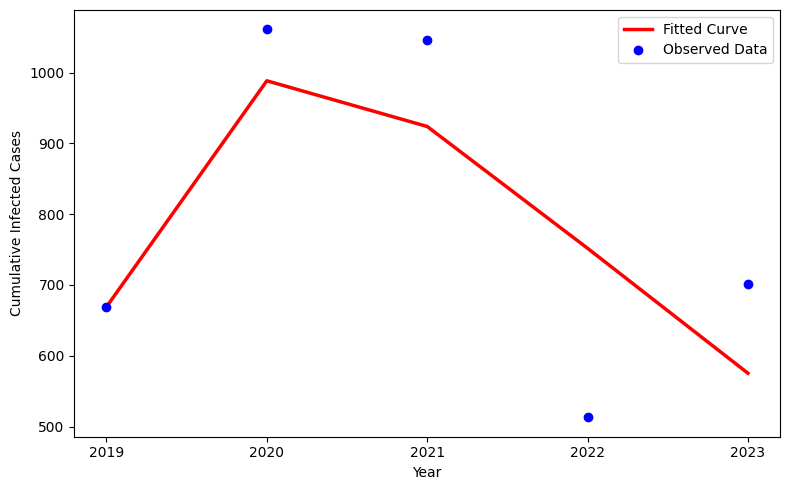

Estimated parameters:
0.29042, 0.80302, 0.57419, 0.58198, 0.06126, 0.81013, 0.48784, 0.61332, 0.52346, 0.59261, 0.21512


In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# -------------------------
# SEIR Model Definition
# -------------------------
def seir_model(y, t, sigma, phi, kappa, epsilon, gamma, alpha, rho, eta, beta, tau, delta):
    S_u, S_a, E_h, I_a, I_s, R, M, S_v, E_v, I_v = y
    N_h = S_u + S_a + E_h + I_a + I_s + R
    N_v = S_v + E_v + I_v

    Lambda_h = 908800
    Lambda_v = 7008000000
    mu = 0.0142
    mu_v = 36.5

    mu1 = 0.001
    mu2 = 0.002
    r = 0.6
    b = 0.6
    c = 0.3
    d = 0.4
    e = 0.8

    dS_udt = r * Lambda_h - (b * beta * I_v * S_u) / N_h - sigma * S_u * M - mu * S_u + phi * S_a
    dS_adt = (1 - r) * Lambda_h - ((1 - eta) * (c * beta * I_v * S_a)) / N_h + sigma * S_u * M - (phi + mu) * S_a
    dE_hdt = ((1 - eta) * (c * beta * I_v * S_a)) / N_h + (b * beta * I_v * S_u) / N_h - (kappa * epsilon + mu) * E_h
    dI_adt = kappa * epsilon * E_h - (gamma + mu + mu1) * I_a
    dI_sdt = (1 - kappa) * epsilon * E_h - (alpha + mu + mu2) * I_s
    dRdt = gamma * I_a + alpha * I_s - mu * R
    dMdt = tau * I_s - delta * M
    dS_vdt = Lambda_v - (d * beta * S_v * I_a) / N_h - (e * beta * S_v * I_s) / N_h - mu_v * S_u
    dE_vdt = (d * beta * S_v * I_a) / N_h + (e * beta * S_v * I_s) / N_h - (rho + mu_v) * E_v
    dI_vdt = rho * E_v - mu_v * I_v

    return [dS_udt, dS_adt, dE_hdt, dI_adt, dI_sdt, dRdt, dMdt, dS_vdt, dE_vdt, dI_vdt]

# -------------------------
# Log-likelihood
# -------------------------
def log_likelihood(params, t, observed_cumulative):
    sigma, phi, kappa, epsilon, gamma, alpha, rho, eta, beta, tau, delta = params
    y0 = [60439692, 1000000, 5000, 469, 669, 3000, 37510300, 49638138, 7802, 1300]
    solution = odeint(seir_model, y0, t, args=(sigma, phi, kappa, epsilon, gamma, alpha, rho, eta, beta, tau, delta))
    predicted_cumulative = solution[:, 4]  # I_s index
    return -0.5 * np.sum((observed_cumulative - predicted_cumulative) ** 2)

# -------------------------
# Load Data
# -------------------------
file_name = '/content/gujarathchiken1.xlsx'
df = pd.read_excel(file_name)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
years_since_min = df['Year'].dt.year - df['Year'].dt.year.min()
infected = df['Cases'].values

# -------------------------
# Optimization
# -------------------------
initial_guess = [0.31156, 0.79717, 0.58081, 0.56596, 0.07115, 0.80174, 0.49206, 0.60680, 0.55839, 0.60010, 0.21726]
neg_log_likelihood = lambda params: -log_likelihood(params, years_since_min, infected)
bounds = [(None, None)] * len(initial_guess)
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
params = result.x

# -------------------------
# Solve ODE with optimized parameters
# -------------------------
y0 = [60439692, 1000000, 5000, 469, 669, 3000, 37510300, 49638138, 7802, 1300]
fitted_solution = odeint(seir_model, y0, years_since_min, args=tuple(params))
predicted_A = fitted_solution[:, 4][:len(infected)]

# -------------------------
# Plot with unique year labels
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(df['Year'].dt.year, predicted_A, 'r-', label='Fitted Curve', linewidth=2.5)
plt.plot(df['Year'].dt.year, infected, 'bo', label='Observed Data', markersize=6)

plt.xlabel('Year')
plt.ylabel('Cumulative Infected Cases')
plt.xticks(sorted(df['Year'].dt.year.unique()))  # Ensure unique years
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# Print parameters
# -------------------------
print("Estimated parameters:")
print(", ".join([f"{p:.5f}" for p in params]))


/tmp/ipython-input-3279917515.py:54: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(seir_model, y0, t, args=(kappa, epsilon, gamma, alpha, eta, beta, tau, delta))


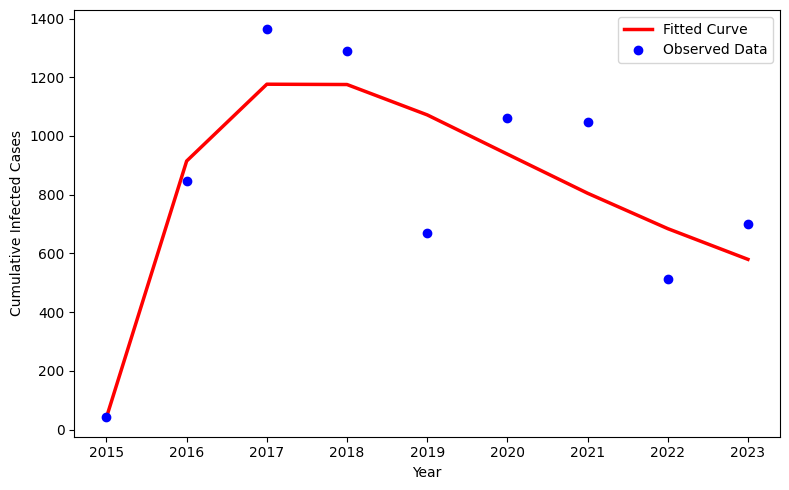

Estimated parameters:
0.37816, 0.45302, 0.11775, 0.66199, 0.66966, 0.67374, 0.63523, 0.30995


In [ ]:
# its good but in next i will develop for the R0
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# -------------------------
# SEIR Model Definition
# -------------------------
def seir_model(y, t,  kappa, epsilon, gamma, alpha, eta, beta, tau, delta):
    S_u, S_a, E_h, I_a, I_s, R, M, S_v, E_v, I_v = y
    N_h = S_u + S_a + E_h + I_a + I_s + R
    N_v = S_v + E_v + I_v

    Lambda_h = 908800
    Lambda_v = 7008000000
    mu = 0.0142
    mu_v = 36.5

    mu1 = 0.001
    mu2 = 0.073
    r = 0.6
    b = 0.6
    c = 0.3
    d = 0.45
    e = 0.8

    sigma = 0.34074
    phi = 0.81425
    rho = 0.52869



    dS_udt = r * Lambda_h - (b * beta * I_v * S_u) / N_h - sigma * S_u * M - mu * S_u + phi * S_a
    dS_adt = (1 - r) * Lambda_h - ((1 - eta) * (c * beta * I_v * S_a)) / N_h + sigma * S_u * M - (phi + mu) * S_a
    dE_hdt = ((1 - eta) * (c * beta * I_v * S_a)) / N_h + (b * beta * I_v * S_u) / N_h - (kappa * epsilon + mu) * E_h
    dI_adt = kappa * epsilon * E_h - (gamma + mu + mu1) * I_a
    dI_sdt = (1 - kappa) * epsilon * E_h - (alpha + mu + mu2) * I_s
    dRdt = gamma * I_a + alpha * I_s - mu * R
    dMdt = tau * I_s - delta * M
    dS_vdt = Lambda_v - (d * beta * S_v * I_a) / N_h - (e * beta * S_v * I_s) / N_h - mu_v * S_u
    dE_vdt = (d * beta * S_v * I_a) / N_h + (e * beta * S_v * I_s) / N_h - (rho + mu_v) * E_v
    dI_vdt = rho * E_v - mu_v * I_v

    return [dS_udt, dS_adt, dE_hdt, dI_adt, dI_sdt, dRdt, dMdt, dS_vdt, dE_vdt, dI_vdt]

# -------------------------
# Log-likelihood
# -------------------------
def log_likelihood(params, t, observed_cumulative):
    kappa, epsilon, gamma, alpha, eta, beta, tau, delta = params
    y0 = [60439692, 1000000, 5000, 469, 42, 3000, 37510300, 49638138, 7802, 1300]
    solution = odeint(seir_model, y0, t, args=(kappa, epsilon, gamma, alpha, eta, beta, tau, delta))
    predicted_cumulative = solution[:, 4]  # I_s index
    return -0.5 * np.sum((observed_cumulative - predicted_cumulative) ** 2)

# -------------------------
# Load Data
# -------------------------
file_name = '/content/gujarathchikenfull2.xlsx'
df = pd.read_excel(file_name)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
years_since_min = df['Year'].dt.year - df['Year'].dt.year.min()
infected = df['Cases'].values

# -------------------------
# Optimization
# -------------------------
initial_guess = [ 0.37816, 0.45302, 0.11775, 0.66199, 0.66966, 0.67374, 0.63523, 0.30995]
neg_log_likelihood = lambda params: -log_likelihood(params, years_since_min, infected)
bounds = [(None, None)] * len(initial_guess)
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
params = result.x

# -------------------------
# Solve ODE with optimized parameters
# -------------------------
y0 = [60439692, 1000000, 5000, 469, 42, 3000, 37510300, 49638138, 7802, 1300]
fitted_solution = odeint(seir_model, y0, years_since_min, args=tuple(params))
predicted_A = fitted_solution[:, 4][:len(infected)]

# -------------------------
# Plot with unique year labels
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(df['Year'].dt.year, predicted_A, 'r-', label='Fitted Curve', linewidth=2.5)
plt.plot(df['Year'].dt.year, infected, 'bo', label='Observed Data', markersize=6)

plt.xlabel('Year')
plt.ylabel('Cumulative Infected Cases')
plt.xticks(sorted(df['Year'].dt.year.unique()))  # Ensure unique years
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# Print parameters
# -------------------------
print("Estimated parameters:")
print(", ".join([f"{p:.5f}" for p in params]))


/tmp/ipython-input-232443538.py:54: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(seir_model, y0, t, args=(kappa, epsilon, gamma, alpha, eta, beta, tau, delta))


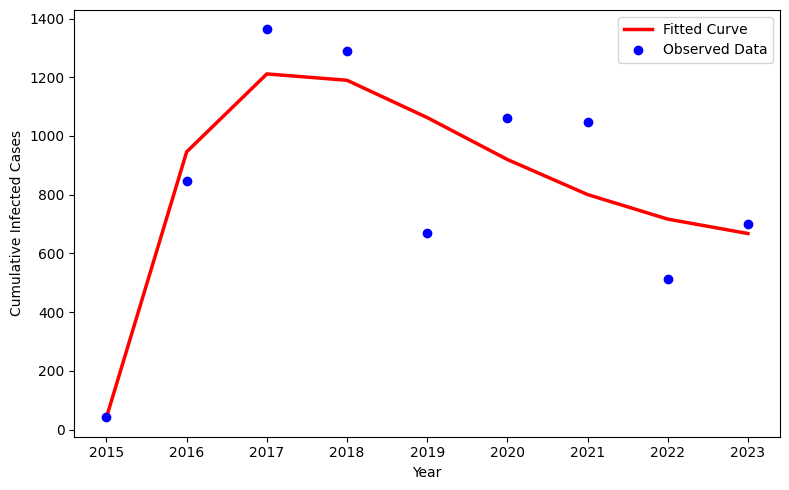

Estimated parameters:
0.49144, 0.56425, 0.31140, 0.51381, 0.88439, 0.11985, 0.17822, 0.13363


In [ ]:
# in this i am trying for R0
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# -------------------------
# SEIR Model Definition
# -------------------------
def seir_model(y, t,  kappa, epsilon, gamma, alpha, eta, beta, tau, delta):
    S_u, S_a, E_h, I_a, I_s, R, M, S_v, E_v, I_v = y
    N_h = S_u + S_a + E_h + I_a + I_s + R
    N_v = S_v + E_v + I_v

    Lambda_h = 908800
    Lambda_v = 7008000000
    mu = 0.0142
    mu_v = 0.5

    mu1 = 0.001
    mu2 = 0.073
    r = 0.6
    b = 0.6
    c = 0.3
    d = 0.45
    e = 0.8

    sigma = 0.34074
    phi = 0.81425
    rho = 0.52869



    dS_udt = r * Lambda_h - (b * beta * I_v * S_u) / N_h - sigma * S_u * M - mu * S_u + phi * S_a
    dS_adt = (1 - r) * Lambda_h - ((1 - eta) * (c * beta * I_v * S_a)) / N_h + sigma * S_u * M - (phi + mu) * S_a
    dE_hdt = ((1 - eta) * (c * beta * I_v * S_a)) / N_h + (b * beta * I_v * S_u) / N_h - (kappa * epsilon + mu) * E_h
    dI_adt = kappa * epsilon * E_h - (gamma + mu + mu1) * I_a
    dI_sdt = (1 - kappa) * epsilon * E_h - (alpha + mu + mu2) * I_s
    dRdt = gamma * I_a + alpha * I_s - mu * R
    dMdt = tau * I_s - delta * M
    dS_vdt = Lambda_v - (d * beta * S_v * I_a) / N_h - (e * beta * S_v * I_s) / N_h - mu_v * S_u
    dE_vdt = (d * beta * S_v * I_a) / N_h + (e * beta * S_v * I_s) / N_h - (rho + mu_v) * E_v
    dI_vdt = rho * E_v - mu_v * I_v

    return [dS_udt, dS_adt, dE_hdt, dI_adt, dI_sdt, dRdt, dMdt, dS_vdt, dE_vdt, dI_vdt]

# -------------------------
# Log-likelihood
# -------------------------
def log_likelihood(params, t, observed_cumulative):
    kappa, epsilon, gamma, alpha, eta, beta, tau, delta = params
    y0 = [60439692, 1000000, 5000, 469, 42, 3000, 37510300, 49638138, 7802, 1300]
    solution = odeint(seir_model, y0, t, args=(kappa, epsilon, gamma, alpha, eta, beta, tau, delta))
    predicted_cumulative = solution[:, 4]  # I_s index
    return -0.5 * np.sum((observed_cumulative - predicted_cumulative) ** 2)

# -------------------------
# Load Data
# -------------------------
file_name = '/content/gujarathchikenfull2.xlsx'
df = pd.read_excel(file_name)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
years_since_min = df['Year'].dt.year - df['Year'].dt.year.min()
infected = df['Cases'].values

# -------------------------
# Optimization
# -------------------------
initial_guess = [0.48939, 0.56302, 0.31158, 0.51199, 0.88468, 0.12015, 0.17718, 0.13396]
neg_log_likelihood = lambda params: -log_likelihood(params, years_since_min, infected)
bounds = [(None, None)] * len(initial_guess)
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
params = result.x

# -------------------------
# Solve ODE with optimized parameters
# -------------------------
y0 = [60439692, 1000000, 5000, 469, 42, 3000, 37510300, 49638138, 7802, 1300]
fitted_solution = odeint(seir_model, y0, years_since_min, args=tuple(params))
predicted_A = fitted_solution[:, 4][:len(infected)]

# -------------------------
# Plot with unique year labels
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(df['Year'].dt.year, predicted_A, 'r-', label='Fitted Curve', linewidth=2.5)
plt.plot(df['Year'].dt.year, infected, 'bo', label='Observed Data', markersize=6)

plt.xlabel('Year')
plt.ylabel('Cumulative Infected Cases')
plt.xticks(sorted(df['Year'].dt.year.unique()))  # Ensure unique years
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# Print parameters
# -------------------------
print("Estimated parameters:")
print(", ".join([f"{p:.5f}" for p in params]))


/tmp/ipython-input-2384325479.py:51: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(seir_model, y0, t, args=(kappa, epsilon, gamma, alpha, eta, beta, tau, delta))


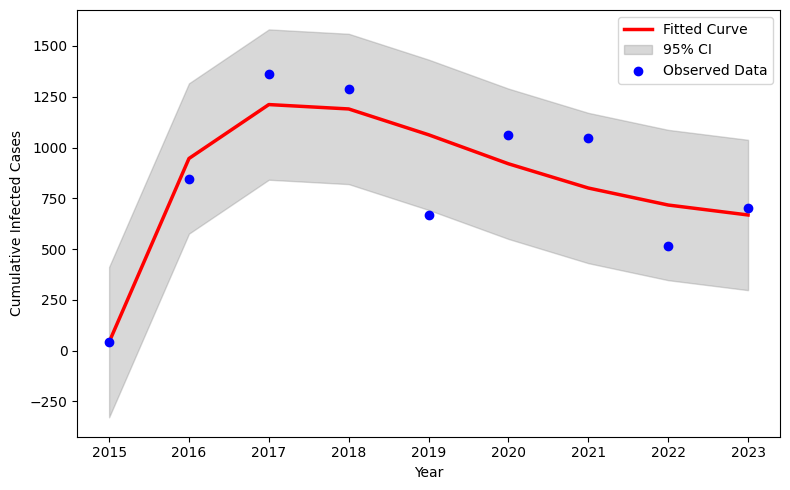

array([0.49144337, 0.56424862, 0.31140372, 0.51380609, 0.88438724,
       0.11984852, 0.17821649, 0.13362565])

In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# -------------------------
# SEIR Model Definition
# -------------------------
def seir_model(y, t, kappa, epsilon, gamma, alpha, eta, beta, tau, delta):
    S_u, S_a, E_h, I_a, I_s, R, M, S_v, E_v, I_v = y
    N_h = S_u + S_a + E_h + I_a + I_s + R
    N_v = S_v + E_v + I_v

    Lambda_h = 908800
    Lambda_v = 7008000000
    mu = 0.0142
    mu_v = 0.5

    mu1 = 0.001
    mu2 = 0.073
    r = 0.6
    b = 0.6
    c = 0.3
    d = 0.45
    e = 0.8

    sigma = 0.34074
    phi = 0.81425
    rho = 0.52869

    dS_udt = r * Lambda_h - (b * beta * I_v * S_u) / N_h - sigma * S_u * M - mu * S_u + phi * S_a
    dS_adt = (1 - r) * Lambda_h - ((1 - eta) * (c * beta * I_v * S_a)) / N_h + sigma * S_u * M - (phi + mu) * S_a
    dE_hdt = ((1 - eta) * (c * beta * I_v * S_a)) / N_h + (b * beta * I_v * S_u) / N_h - (kappa * epsilon + mu) * E_h
    dI_adt = kappa * epsilon * E_h - (gamma + mu + mu1) * I_a
    dI_sdt = (1 - kappa) * epsilon * E_h - (alpha + mu + mu2) * I_s
    dRdt = gamma * I_a + alpha * I_s - mu * R
    dMdt = tau * I_s - delta * M
    dS_vdt = Lambda_v - (d * beta * S_v * I_a) / N_h - (e * beta * S_v * I_s) / N_h - mu_v * S_u
    dE_vdt = (d * beta * S_v * I_a) / N_h + (e * beta * S_v * I_s) / N_h - (rho + mu_v) * E_v
    dI_vdt = rho * E_v - mu_v * I_v

    return [dS_udt, dS_adt, dE_hdt, dI_adt, dI_sdt, dRdt, dMdt, dS_vdt, dE_vdt, dI_vdt]

# -------------------------
# Log-likelihood
# -------------------------
def log_likelihood(params, t, observed_cumulative):
    kappa, epsilon, gamma, alpha, eta, beta, tau, delta = params
    y0 = [60439692, 1000000, 5000, 469, 42, 3000, 37510300, 49638138, 7802, 1300]
    solution = odeint(seir_model, y0, t, args=(kappa, epsilon, gamma, alpha, eta, beta, tau, delta))
    predicted_cumulative = solution[:, 4]  # I_s index
    return -0.5 * np.sum((observed_cumulative - predicted_cumulative) ** 2)

# -------------------------
# Load Data
# -------------------------
file_name = '/content/gujarathchikenfull2.xlsx'
df = pd.read_excel(file_name)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
years_since_min = df['Year'].dt.year - df['Year'].dt.year.min()
infected = df['Cases'].values

# -------------------------
# Optimization
# -------------------------
initial_guess = [0.48939, 0.56302, 0.31158, 0.51199, 0.88468, 0.12015, 0.17718, 0.13396]
neg_log_likelihood = lambda params: -log_likelihood(params, years_since_min, infected)
bounds = [(None, None)] * len(initial_guess)
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
params = result.x

# -------------------------
# Solve ODE with optimized parameters
# -------------------------
y0 = [60439692, 1000000, 5000, 469, 42, 3000, 37510300, 49638138, 7802, 1300]
fitted_solution = odeint(seir_model, y0, years_since_min, args=tuple(params))
predicted_A = fitted_solution[:, 4][:len(infected)]

# -------------------------
# Simple residual-based 95% CI
# -------------------------
residuals = infected - predicted_A
std_error = np.std(residuals)
ci_upper = predicted_A + 1.96 * std_error
ci_lower = predicted_A - 1.96 * std_error

# -------------------------
# Plot with CI
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(df['Year'].dt.year, predicted_A, 'r-', label='Fitted Curve', linewidth=2.5)
plt.fill_between(df['Year'].dt.year, ci_lower, ci_upper, color='gray', alpha=0.3, label='95% CI')
plt.plot(df['Year'].dt.year, infected, 'bo', label='Observed Data', markersize=6)

plt.xlabel('Year')
plt.ylabel('Cumulative Infected Cases')
plt.xticks(sorted(df['Year'].dt.year.unique()))
plt.legend()
plt.tight_layout()
plt.show()

params


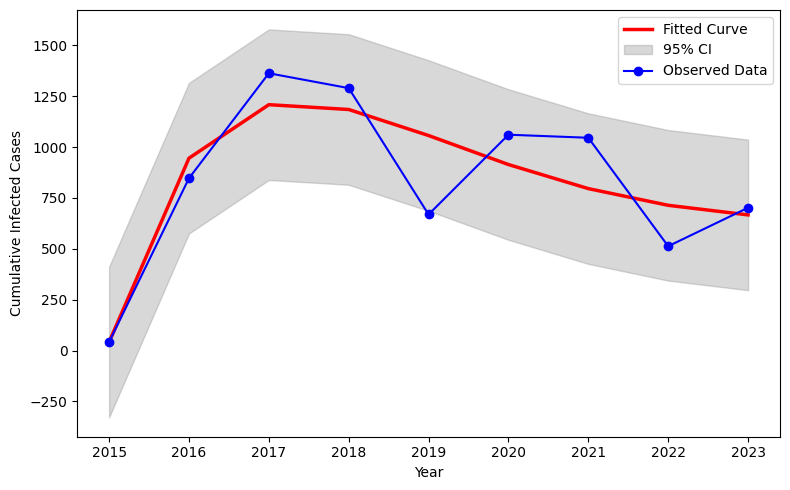

Estimated parameters:
0.49267, 0.56655, 0.31350, 0.51601, 0.88427, 0.12125, 0.17719, 0.13398


In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# -------------------------
# SEIR Model Definition
# -------------------------
def seir_model(y, t, kappa, epsilon, gamma, alpha, eta, beta, tau, delta):
    S_u, S_a, E_h, I_a, I_s, R, M, S_v, E_v, I_v = y
    N_h = S_u + S_a + E_h + I_a + I_s + R
    N_v = S_v + E_v + I_v

    Lambda_h = 908800
    Lambda_v = 7008000000
    mu = 0.0142
    mu_v = 0.5

    mu1 = 0.001
    mu2 = 0.073
    b = 0.6
    c = 0.3
    d = 0.45
    e = 0.8

    sigma = 0.34074
    phi = 0.81425
    rho = 0.52869

    dS_udt =  Lambda_h - (b * beta * I_v * S_u) / N_h - sigma * S_u * M - mu * S_u + phi * S_a
    dS_adt =  -((1 - eta) * (c * beta * I_v * S_a)) / N_h + sigma * S_u * M - (phi + mu) * S_a
    dE_hdt = ((1 - eta) * (c * beta * I_v * S_a)) / N_h + (b * beta * I_v * S_u) / N_h - (kappa * epsilon + mu) * E_h
    dI_adt = kappa * epsilon * E_h - (gamma + mu + mu1) * I_a
    dI_sdt = (1 - kappa) * epsilon * E_h - (alpha + mu + mu2) * I_s
    dRdt = gamma * I_a + alpha * I_s - mu * R
    dMdt = tau * I_s - delta * M
    dS_vdt = Lambda_v - (d * beta * S_v * I_a) / N_h - (e * beta * S_v * I_s) / N_h - mu_v * S_u
    dE_vdt = (d * beta * S_v * I_a) / N_h + (e * beta * S_v * I_s) / N_h - (rho + mu_v) * E_v
    dI_vdt = rho * E_v - mu_v * I_v

    return [dS_udt, dS_adt, dE_hdt, dI_adt, dI_sdt, dRdt, dMdt, dS_vdt, dE_vdt, dI_vdt]

# -------------------------
# Log-likelihood
# -------------------------
def log_likelihood(params, t, observed_cumulative):
    kappa, epsilon, gamma, alpha, eta, beta, tau, delta = params
    y0 = [60439692, 1000000, 5000, 469, 42, 3000, 37510300, 49638138, 7802, 1300]
    solution = odeint(seir_model, y0, t, args=(kappa, epsilon, gamma, alpha, eta, beta, tau, delta))
    predicted_cumulative = solution[:, 4]  # I_s index
    return -0.5 * np.sum((observed_cumulative - predicted_cumulative) ** 2)

# -------------------------
# Load Data
# -------------------------
file_name = '/content/gujarathchikenfull2.xlsx'
df = pd.read_excel(file_name)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
years_since_min = df['Year'].dt.year - df['Year'].dt.year.min()
infected = df['Cases'].values

# -------------------------
# Optimization
# -------------------------
initial_guess = [0.48939, 0.56302, 0.31158, 0.51199, 0.88468, 0.12015, 0.17718, 0.13396]
neg_log_likelihood = lambda params: -log_likelihood(params, years_since_min, infected)
bounds = [(None, None)] * len(initial_guess)
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
params = result.x

# -------------------------
# Solve ODE with optimized parameters
# -------------------------
y0 = [60439692, 1000000, 5000, 469, 42, 3000, 37510300, 49638138, 7802, 1300]
fitted_solution = odeint(seir_model, y0, years_since_min, args=tuple(params))
predicted_A = fitted_solution[:, 4][:len(infected)]

# -------------------------
# Simple residual-based 95% CI
# -------------------------
residuals = infected - predicted_A
std_error = np.std(residuals)
ci_upper = predicted_A + 1.96 * std_error
ci_lower = predicted_A - 1.96 * std_error

# -------------------------
# Plot with CI
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(df['Year'].dt.year, predicted_A, 'r-', label='Fitted Curve', linewidth=2.5)
plt.fill_between(df['Year'].dt.year, ci_lower, ci_upper, color='gray', alpha=0.3, label='95% CI')
plt.plot(df['Year'].dt.year, infected, 'bo', label='Observed Data', markersize=6)

plt.xlabel('Year')
plt.ylabel('Cumulative Infected Cases')
plt.xticks(sorted(df['Year'].dt.year.unique()))
plt.legend()
plt.tight_layout()
plt.show()

print("Estimated parameters:")
print(", ".join([f"{p:.5f}" for p in params]))

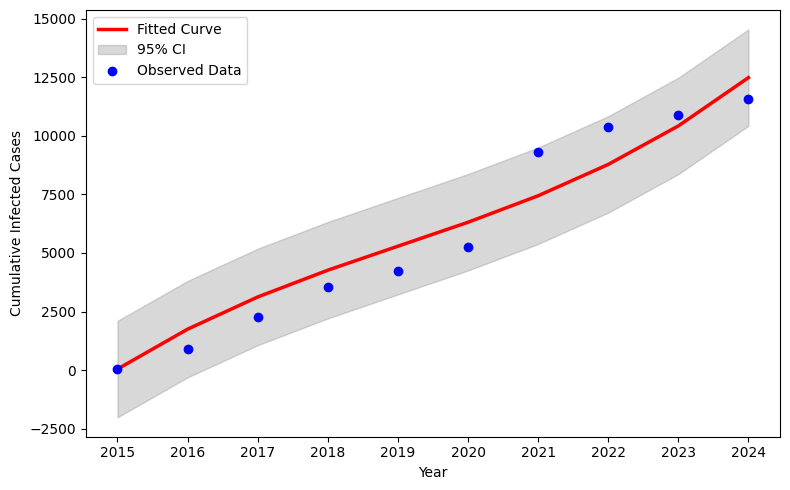

Estimated parameters:
0.35630, 0.58992, 0.30834, 0.50619, 0.85274, 0.18824, 0.17681, 0.12933


In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# -------------------------
# SEIR Model Definition
# -------------------------
def seir_model(y, t, kappa, epsilon, gamma, alpha, eta, beta, tau, delta):
    S_u, S_a, E_h, I_a, I_s, R, M, S_v, E_v, I_v, C = y
    N_h = S_u + S_a + E_h + I_a + I_s + R
    N_v = S_v + E_v + I_v

    Lambda_h = 908800
    Lambda_v = 7008000000
    mu = 0.0142
    mu_v = 0.5

    mu1 = 0.001
    mu2 = 0.073
    b = 0.6
    c = 0.3
    d = 0.45
    e = 0.8

    sigma = 0.34074
    phi = 0.81425
    rho = 0.52869

    dS_udt =  Lambda_h - (b * beta * I_v * S_u) / N_h - sigma * S_u * M - mu * S_u + phi * S_a
    dS_adt =  -((1 - eta) * (c * beta * I_v * S_a)) / N_h + sigma * S_u * M - (phi + mu) * S_a
    dE_hdt = ((1 - eta) * (c * beta * I_v * S_a)) / N_h + (b * beta * I_v * S_u) / N_h - (kappa * epsilon + mu) * E_h
    dI_adt = kappa * epsilon * E_h - (gamma + mu + mu1) * I_a
    dI_sdt = (1 - kappa) * epsilon * E_h - (alpha + mu + mu2) * I_s
    dRdt = gamma * I_a + alpha * I_s - mu * R
    dMdt = tau * I_s - delta * M
    dS_vdt = Lambda_v - (d * beta * S_v * I_a) / N_h - (e * beta * S_v * I_s) / N_h - mu_v * S_u
    dE_vdt = (d * beta * S_v * I_a) / N_h + (e * beta * S_v * I_s) / N_h - (rho + mu_v) * E_v
    dI_vdt = rho * E_v - mu_v * I_v
    dCdt = (1 - kappa) * epsilon * E_h


    return [dS_udt, dS_adt, dE_hdt, dI_adt, dI_sdt, dRdt, dMdt, dS_vdt, dE_vdt, dI_vdt, dCdt]

# -------------------------
# Log-likelihood
# -------------------------
def log_likelihood(params, t, observed_cumulative):
    kappa, epsilon, gamma, alpha, eta, beta, tau, delta = params
    y0 = [60439692, 1000000, 5000, 469, 42, 3000, 37510300, 49638138, 7802, 1300, 42]
    solution = odeint(seir_model, y0, t, args=(kappa, epsilon, gamma, alpha, eta, beta, tau, delta))
    predicted_cumulative = solution[:, 10]  # I_s index
    return -0.5 * np.sum((observed_cumulative - predicted_cumulative) ** 2)

# -------------------------
# Load Data
# -------------------------
file_name = '/content/gujarathchikencumulative.xlsx'
df = pd.read_excel(file_name)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
years_since_min = df['Year'].dt.year - df['Year'].dt.year.min()
infected = df['Cases'].values

# -------------------------
# Optimization
# -------------------------
initial_guess = [0.48939, 0.56302, 0.31158, 0.51199, 0.88468, 0.12015, 0.17718, 0.13396]
neg_log_likelihood = lambda params: -log_likelihood(params, years_since_min, infected)
bounds = [(None, None)] * len(initial_guess)
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
params = result.x

# -------------------------
# Solve ODE with optimized parameters
# -------------------------
y0 = [60439692, 1000000, 5000, 469, 42, 3000, 37510300, 49638138, 7802, 1300, 42]
fitted_solution = odeint(seir_model, y0, years_since_min, args=tuple(params))
predicted_A = fitted_solution[:, 10][:len(infected)]

# -------------------------
# Simple residual-based 95% CI
# -------------------------
residuals = infected - predicted_A
std_error = np.std(residuals)
ci_upper = predicted_A + 1.96 * std_error
ci_lower = predicted_A - 1.96 * std_error

# -------------------------
# Plot with CI
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(df['Year'].dt.year, predicted_A, 'r-', label='Fitted Curve', linewidth=2.5)
plt.fill_between(df['Year'].dt.year, ci_lower, ci_upper, color='gray', alpha=0.3, label='95% CI')
plt.plot(df['Year'].dt.year, infected, 'bo', label='Observed Data', markersize=6)

plt.xlabel('Year')
plt.ylabel('Cumulative Infected Cases')
plt.xticks(sorted(df['Year'].dt.year.unique()))
plt.legend()
plt.tight_layout()
plt.show()

print("Estimated parameters:")
print(", ".join([f"{p:.5f}" for p in params]))

/tmp/ipython-input-2764594697.py:52: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(seir_model, y0, t, args=(kappa, epsilon, gamma, alpha, eta, beta, tau, delta))


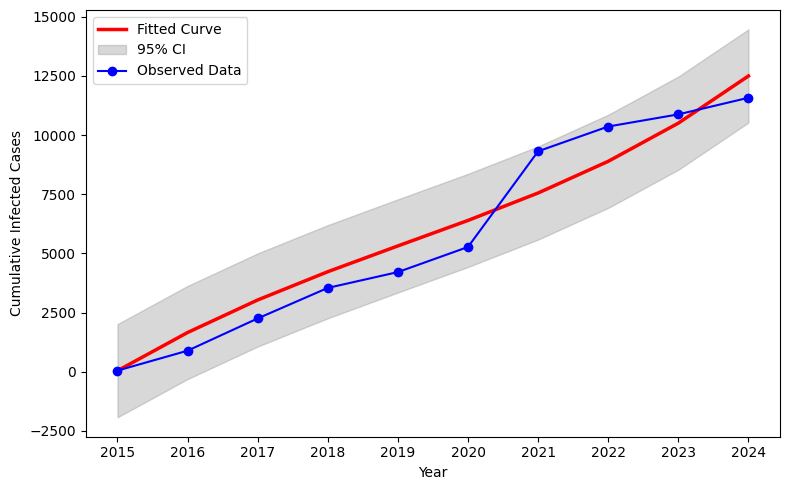

Estimated parameters:
0.30449, 0.50368, 0.17327, 0.37665, 0.88633, 0.18265, 0.50168, 0.02077


In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# -------------------------
# SEIR Model Definition
# -------------------------
def seir_model(y, t, kappa, epsilon, gamma, alpha, eta, beta, tau, delta):
    S_u, S_a, E_h, I_a, I_s, R, M, S_v, E_v, I_v, C = y
    N_h = S_u + S_a + E_h + I_a + I_s + R
    N_v = S_v + E_v + I_v

    Lambda_h = 908800
    Lambda_v = 7008000000
    mu = 0.0142
    mu_v = 0.5

    mu1 = 0.001
    mu2 = 0.073
    b = 0.6
    c = 0.3
    d = 0.45
    e = 0.8

    sigma = 0.34074
    phi = 0.81425
    rho = 0.52869

    dS_udt =  Lambda_h - (b * beta * I_v * S_u) / N_h - sigma * S_u * M - mu * S_u + phi * S_a
    dS_adt =  -((1 - eta) * (c * beta * I_v * S_a)) / N_h + sigma * S_u * M - (phi + mu) * S_a
    dE_hdt = ((1 - eta) * (c * beta * I_v * S_a)) / N_h + (b * beta * I_v * S_u) / N_h - (kappa * epsilon + mu) * E_h
    dI_adt = kappa * epsilon * E_h - (gamma + mu + mu1) * I_a
    dI_sdt = (1 - kappa) * epsilon * E_h - (alpha + mu + mu2) * I_s
    dRdt = gamma * I_a + alpha * I_s - mu * R
    dMdt = tau * I_s - delta * M
    dS_vdt = Lambda_v - (d * beta * S_v * I_a) / N_h - (e * beta * S_v * I_s) / N_h - mu_v * S_u
    dE_vdt = (d * beta * S_v * I_a) / N_h + (e * beta * S_v * I_s) / N_h - (rho + mu_v) * E_v
    dI_vdt = rho * E_v - mu_v * I_v
    dCdt = (1 - kappa) * epsilon * E_h


    return [dS_udt, dS_adt, dE_hdt, dI_adt, dI_sdt, dRdt, dMdt, dS_vdt, dE_vdt, dI_vdt, dCdt]

# -------------------------
# Log-likelihood
# -------------------------
def log_likelihood(params, t, observed_cumulative):
    kappa, epsilon, gamma, alpha, eta, beta, tau, delta = params
    y0 = [60439692, 1000000, 5000, 469, 42, 3000, 37510300, 49638138, 7802, 1300, 42]
    solution = odeint(seir_model, y0, t, args=(kappa, epsilon, gamma, alpha, eta, beta, tau, delta))
    predicted_cumulative = solution[:, 10]  # I_s index
    return -0.5 * np.sum((observed_cumulative - predicted_cumulative) ** 2)

# -------------------------
# Load Data
# -------------------------
file_name = '/content/gujarathchikencumulative.xlsx'
df = pd.read_excel(file_name)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
years_since_min = df['Year'].dt.year - df['Year'].dt.year.min()
infected = df['Cases'].values

# -------------------------
# Optimization
# -------------------------
initial_guess = [0.51415, 0.15016, 0.16579, 0.38375, 0.90233, 0.15706, 0.50976, 0.01075]
neg_log_likelihood = lambda params: -log_likelihood(params, years_since_min, infected)
bounds = [(None, None)] * len(initial_guess)
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
params = result.x

# -------------------------
# Solve ODE with optimized parameters
# -------------------------
y0 = [60439692, 1000000, 5000, 469, 42, 3000, 37510300, 49638138, 7802, 1300, 42]
fitted_solution = odeint(seir_model, y0, years_since_min, args=tuple(params))
predicted_A = fitted_solution[:, 10][:len(infected)]

# -------------------------
# Simple residual-based 95% CI
# -------------------------
residuals = infected - predicted_A
std_error = np.std(residuals)
ci_upper = predicted_A + 1.96 * std_error
ci_lower = predicted_A - 1.96 * std_error

# -------------------------
# Plot with CI
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(df['Year'].dt.year, predicted_A, 'r-', label='Fitted Curve', linewidth=2.5)
plt.fill_between(df['Year'].dt.year, ci_lower, ci_upper, color='gray', alpha=0.3, label='95% CI')
plt.plot(df['Year'].dt.year, infected, 'bo-', label='Observed Data', markersize=6)

plt.xlabel('Year')
plt.ylabel('Cumulative Infected Cases')
plt.xticks(sorted(df['Year'].dt.year.unique()))
plt.legend()
plt.tight_layout()

# ✅ Save before showing
plt.savefig('gujarath_Cumulative_chiken.png', dpi=300, bbox_inches='tight')
plt.show()

print("Estimated parameters:")
print(", ".join([f"{p:.5f}" for p in params]))